<a href="https://colab.research.google.com/github/Satwikram/Image-Segmentation/blob/main/Image%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

What is image segmentation?


So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

**Dataset link: https://www.robots.ox.ac.uk/~vgg/data/pets/**

### Importing Dependencies

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output

### Downloading the dataset

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteGA3SLL/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteGA3SLL/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [ ]:
dataset

{'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}

### Normalizing the Data

In [ ]:
def normalize(input_image, input_mask):

  input_image = tf.cast(input_image, tf.float32) / 255.0

  input_mask -= 1

  return input_image, input_mask

### Function to Load the Train Images

In [ ]:
tf.random.uniform((), seed = 2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6787466>

In [ ]:
@tf.function
def load_image_train(datapoint):

  input_image = tf.image.resize(datapoint['image'], (128, 128))

  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:

    input_image = tf.image.flip_left_right(input_image)

    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

### Function to Load the Test Images

In [ ]:
def load_image_test(datapoint):

  input_image = tf.image.resize(datapoint['image'], (128, 128))
  
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

### Loading Train and Test Dataset

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train

<ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [ ]:
test = dataset['test'].map(load_image_test)

In [ ]:
test

<MapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [ ]:
train.cache()

<CacheDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

### Taking Train and Test Dataset

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test.batch(BATCH_SIZE)

### Displaying Image

In [ ]:
def display(display_list):
  
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

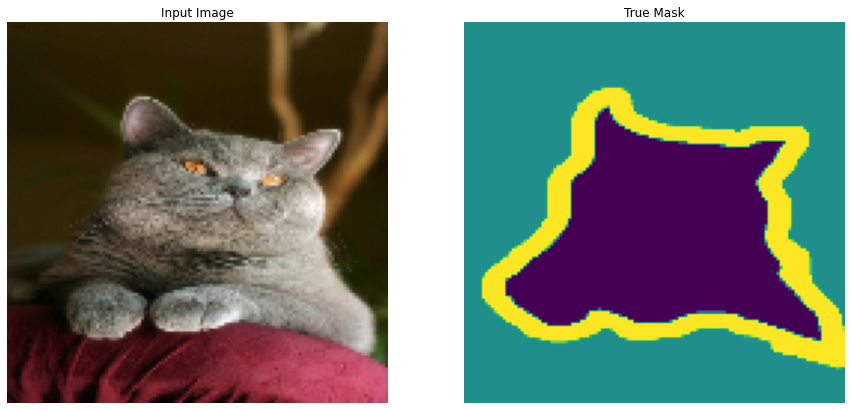

In [ ]:
for image, mask in train.take(3):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
OUTPUT_CHANNELS = 3

### Building the model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = [128, 128, 3], include_top = False)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

In [ ]:
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

In [ ]:
# Create the feature extraction model
down_stack = tf.keras.Model(inputs = base_model.input, outputs = base_model_outputs)

In [ ]:
down_stack.trainable = False

In [ ]:
up_stack = [
            
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):

  inputs = tf.keras.layers.Input(shape = [128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)

  x = skips[-1]

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)

### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

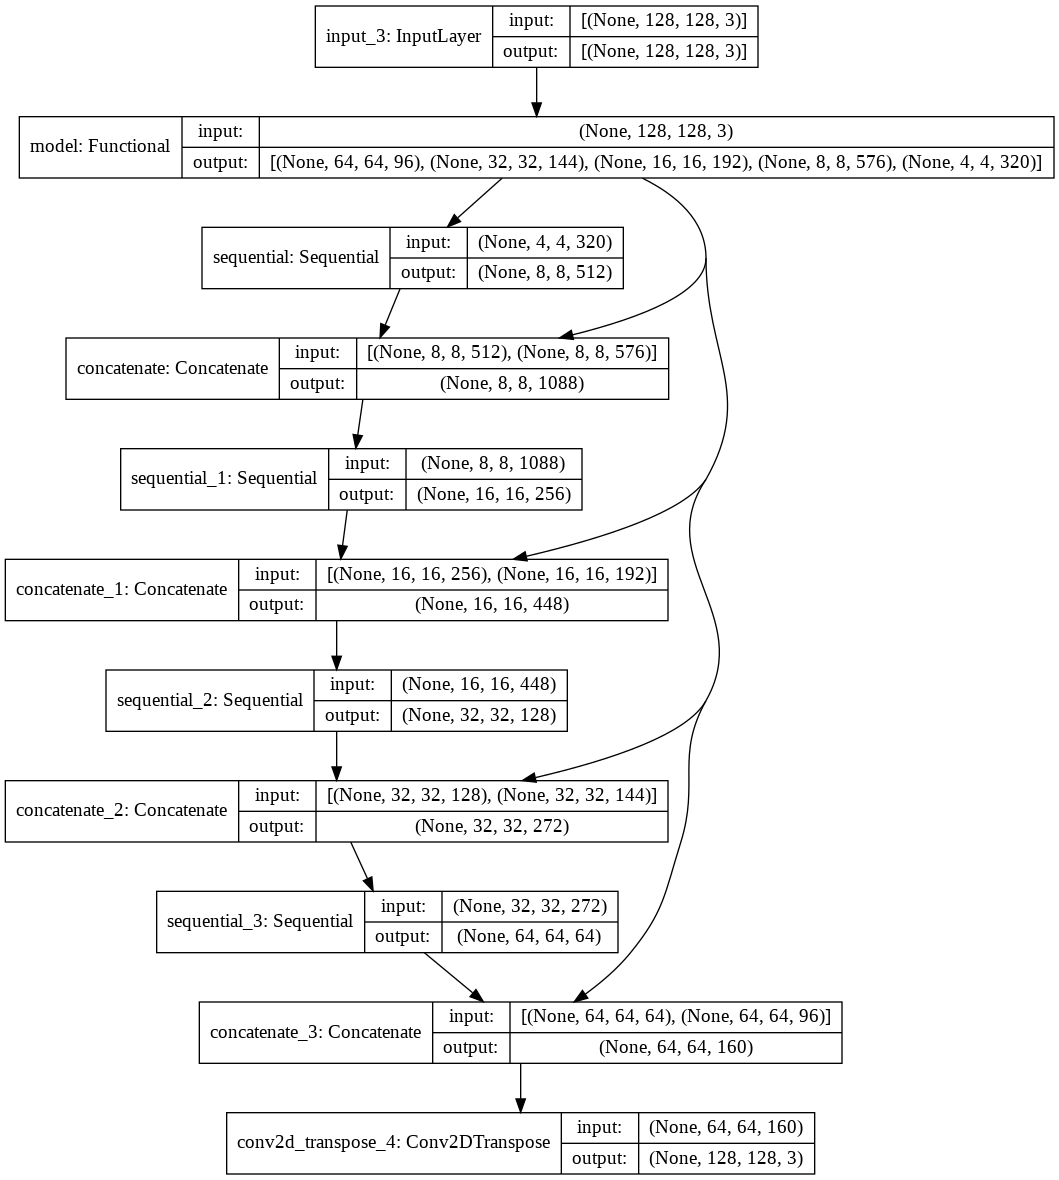

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Create Mask Function

In [ ]:
def create_mask(pred_mask):

  pred_mask = tf.argmax(pred_mask, axis=-1)

  pred_mask = pred_mask[..., tf.newaxis]
  
  return pred_mask[0]

### Show Predictions

In [ ]:
def show_predictions(dataset=None, num=1):
  
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

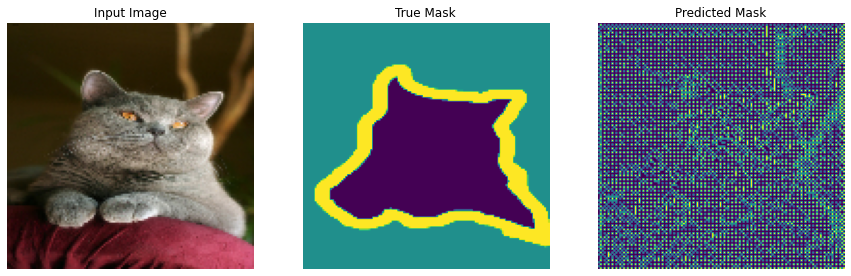

In [ ]:
show_predictions()

### Callbacks

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Segmentation/segment.hdf5', 'val_loss',
                                               verbose = 1, save_best_only = True, 
                                               mode = 'min')

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0,
                                             patience = 3, verbose = 1, mode = 'min',
                                             restore_best_weights = True)

In [ ]:
callbacks = [DisplayCallback(), checkpoint, earlystop]

### Training

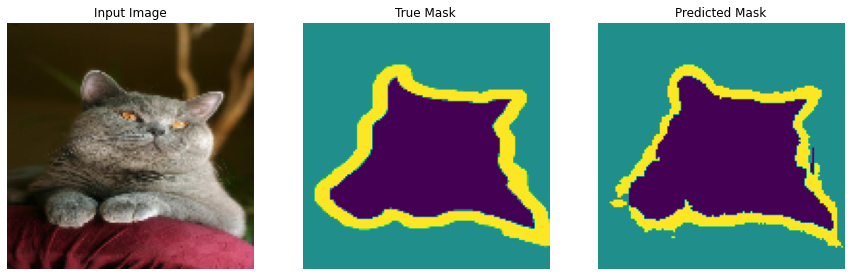


Sample Prediction after epoch 4


Epoch 00004: val_loss did not improve from 0.26353
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks = callbacks)

### Loading the model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Segmentation/segment.hdf5')

In [ ]:
loaded_model.weights

[<tf.Variable 'Conv1/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[ 1.60920480e-03, -1.45352582e-22,  1.54917374e-01,
            2.29649822e-06,  1.49279218e-02, -5.39761280e-21,
            7.01060288e-21,  1.54408276e-21, -1.12762444e-01,
           -2.37320393e-01,  2.77190953e-01,  5.03320247e-02,
           -4.21045721e-01,  1.73461720e-01, -5.35633206e-01,
           -5.95900055e-04,  5.34933396e-02,  2.24988922e-01,
           -1.49572559e-22,  2.20291526e-03, -5.38195252e-01,
           -2.21309029e-02, -4.88732375e-22, -3.89234926e-21,
            2.84152419e-22, -1.23437764e-02, -1.14439223e-02,
            1.46071922e-22, -4.24997229e-03, -2.48236431e-09,
           -4.64977883e-02, -3.43741417e-01],
          [ 1.25032081e-03, -2.00014382e-22,  2.32940048e-01,
            2.78269158e-06,  1.99653972e-02,  7.11864268e-20,
            6.08769832e-21,  2.95990709e-22, -2.76436746e-01,
           -5.15990913e-01,  6.78669810e-01,  3.02553400e-02,
           -7

### Testing

In [ ]:
def show_predictions_test(dataset=None, num=1):
  
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = loaded_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(loaded_model.predict(sample_image[tf.newaxis, ...]))])

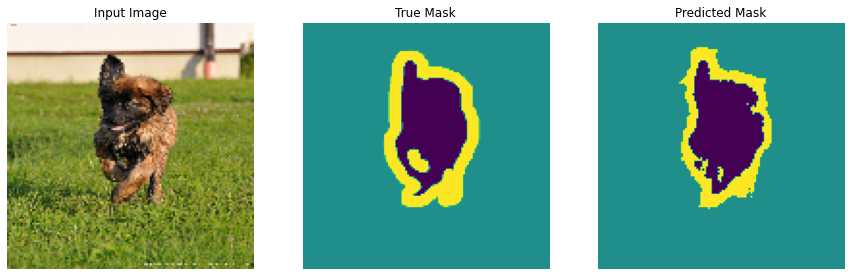

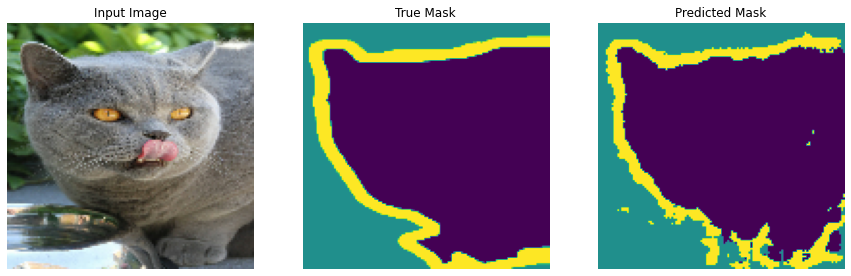

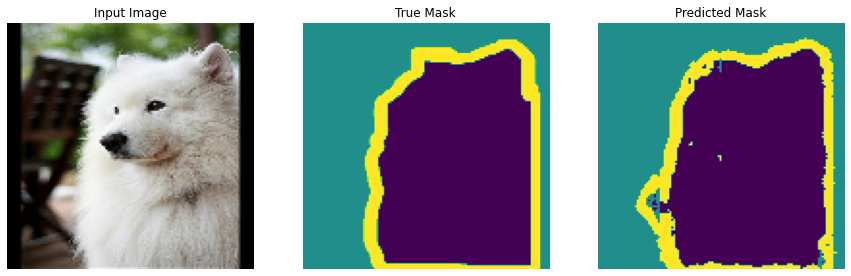

In [ ]:
show_predictions_test(test_dataset, 3)

### Single Prediction